In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import glob
import librosa
import librosa.display
import datasets.dcase_few_shot_bioacoustic as util
import datasets.data_gen as dg
import matplotlib.pyplot as plt
import datasets.dcase_few_shot_bioacoustic as util

import IPython.display as ipd

import h5py

import scipy

import datasets.data_gen as dg

In [84]:
np.random.random() > 0.5

True

In [3]:
class ConfigDummy():
    
    def __init__(self):
        self.experiment = Experiment()
        
class Experiment():
    
    def __init__(self):
        self.datagen = Datagen()
        self.path = Path()

class Path():
    
    def __init__(self):
        self.train_features = '/home/willbo/data/dcase/hfiles/train'
        
class Datagen():
    
    def __init__(self):
        self.ltoi = True
        self.balance = True
        self.normalize = True
        self.raw = False

config = ConfigDummy()
gen = dg.Datagen(config)

In [3]:
ls '/home/willbo/data/dcase/val'

a1.csv                    BUK4_20161011_000804.csv   BUK5_20180921_015906a.csv
a1.wav                    BUK4_20161011_000804.wav   BUK5_20180921_015906a.wav
BUK1_20181011_001004.csv  BUK4_20171022_004304a.csv  n1.csv
BUK1_20181011_001004.wav  BUK4_20171022_004304a.wav  n1.wav
BUK1_20181013_023504.csv  BUK5_20161101_002104a.csv
BUK1_20181013_023504.wav  BUK5_20161101_002104a.wav


In [11]:
root_path = '/home/willbo/data/dcase/val/'
filename = 'BUK5_20180921_015906a'

annotation_file_path = os.path.join(root_path, filename) + '.csv'
audio_file_path = os.path.join(root_path, filename) + '.wav'
print(annotation_file_path)
print(audio_file_path)

/home/willbo/data/dcase/val/BUK5_20180921_015906a.csv
/home/willbo/data/dcase/val/BUK5_20180921_015906a.wav


In [5]:
def select_events_with_value(data_frame, value='POS'):
    indices = data_frame.index[data_frame['class'] == value].tolist()
    return indices

def build_matrix_from_selected_rows(data_frame, selected_indices):
    matrix_data = np.ones((2, len(selected_indices)))* -1
    for n, idx in enumerate(selected_indices):
        matrix_data[0, n] = data_frame.loc[idx]['start-time']
        matrix_data[1, n] = data_frame.loc[idx]['end-time']
    return matrix_data

def load_prediction_dataframe(prediction_file_path, annotation_file_path, filename):
    prediction_dataframe = pd.read_csv(prediction_file_path)
    prediction_dataframe['class'] = 'POS'
    prediction_dataframe.columns = ['filename', 'start-time', 'end-time', 'class']
    predicted_events_by_audiofile = dict(tuple(prediction_dataframe.groupby('filename')))
    prediction_dataframe = predicted_events_by_audiofile[filename + '.wav']
    
    annotation_dataframe = load_annotation_dataframe(annotation_file_path)
    
    ref_pos_indices = select_events_with_value(annotation_dataframe, value='POS')
    pred_pos_indices = select_events_with_value(prediction_dataframe, value='POS')

    ref_1st_round = build_matrix_from_selected_rows(annotation_dataframe, ref_pos_indices)
    pred_1st_round = build_matrix_from_selected_rows(prediction_dataframe, pred_pos_indices)

    m_pos = util.match_events(ref_1st_round, pred_1st_round, min_iou=0.3)
    tp_indices = np.array([x[1] for x in m_pos])
    for i, (index, row) in enumerate(prediction_dataframe.iterrows()):
        if i in tp_indices:
            prediction_dataframe.at[index, 'class'] = 'TP'
        else:
            prediction_dataframe.at[index, 'class'] = 'FP'
    
    return prediction_dataframe

def load_annotation_dataframe(file_path):
    annotation_dataframe = pd.read_csv(file_path)
    annotation_dataframe.columns = ['filename', 'start-time', 'end-time', 'class']
    
    return annotation_dataframe

In [6]:
prediction_file_path = '/home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/rbigg_specaugemnt_lazytest_l2_650neg_lr5_notile02/PP_BEST_VAL_out.csv'
prediction_df = load_prediction_dataframe(prediction_file_path, annotation_file_path, filename)
prediction_df[:5]

,filename,start-time,end-time,class
317,BUK5_20180921_015906a.wav,556.025083,556.210833,TP
318,BUK5_20180921_015906a.wav,560.436833,560.483333,FP
319,BUK5_20180921_015906a.wav,579.523667,579.570083,FP
320,BUK5_20180921_015906a.wav,585.328667,585.421500,TP
321,BUK5_20180921_015906a.wav,585.978833,586.025250,FP


In [7]:
annotation_df = load_annotation_dataframe(annotation_file_path)
annotation_df[:5]

,filename,start-time,end-time,class
0,BUK5_20180921_015906a.wav,59.172129,59.324067,POS
1,BUK5_20180921_015906a.wav,62.150508,62.359799,POS
2,BUK5_20180921_015906a.wav,64.583521,64.605658,POS
3,BUK5_20180921_015906a.wav,133.728187,133.764411,POS
4,BUK5_20180921_015906a.wav,237.660515,237.753086,POS


In [8]:
sr = 22050
audio, sr = librosa.load(audio_file_path, sr)

In [36]:
e_st = annotation_df['start-time'][2]
e_et = annotation_df['end-time'][2]
if(e_et - e_st < 0.2):
    i = (0.2 + e_st - e_et)/2
    e_st = e_st - i
    e_et = e_et + i



In [37]:
e_st_i = int(e_st * sr)
e_et_i = int(e_et * sr)

audio_segment = audio[e_st_i:e_et_i]

It might very well be weird to do PCEN on this short segments. Should perhaps be done over the whole file.
Need to do s -> frame#

In [11]:
audio_b = audio * (2**32)

In [63]:
D_mel = librosa.feature.melspectrogram(audio_b, sr=22050, n_fft=1024, hop_length=256, n_mels=128, fmax=10000, fmin=6000)
D_pcen = librosa.core.pcen(D_mel, sr)

In [13]:
D_pcen.shape

(128, 154695)

In [39]:
def time_2_frame(start_time, end_time, fps):
    
    start_time = start_time
    end_time = end_time
    
    start_time = [int(np.floor(start * fps)) for start in start_time]
    end_time = [int(np.floor(end * fps)) for end in end_time]
    
    return start_time, end_time

In [47]:
s_f, e_f = time_2_frame(np.array([e_st]), np.array([e_et]), sr/256)
print(s_f)
print(e_f)

[5555]
[5572]


In [16]:
D_pcen.T[s_f[0]:e_f[0]].shape

(17, 128)

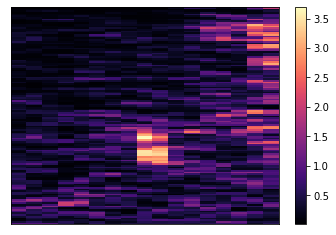

In [64]:
plt.figure()
librosa.display.specshow((D_pcen.T[s_f[0]:e_f[0]].T))
plt.colorbar()

In [42]:
h5 = h5py.File('/home/willbo/data/dcase/features/hfiles/val/'+filename+'.h5')
print(h5.keys())
mean = h5['mean_global'][:][0]
std = h5['std_global'][:][0]

<KeysViewHDF5 ['feat_neg', 'feat_pos', 'feat_query', 'mean_global', 'start_index_query', 'std_global']>


In [12]:
plt.figure()
librosa.display.specshow((D_pcen.T[s_f[0]:e_f[0]].T - mean)/std)
plt.colorbar()

NameError: name 'D_pcen' is not defined

<Figure size 432x288 with 0 Axes>

(128, 17)


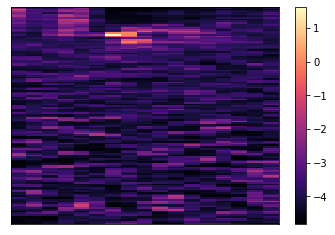

In [18]:
n_l_s = s_f[0] - (e_f[0] - s_f[0])
n_l_s_2 = s_f[0] - (e_f[0] - s_f[0])*2
n_l = D_pcen.T[n_l_s:s_f[0]].T
n_l_2 = D_pcen.T[n_l_s_2:n_l_s].T
n_r_e = e_f[0] + (e_f[0] - s_f[0])
n_r_e_2 = e_f[0] + (e_f[0] - s_f[0])*2
n_r = D_pcen.T[e_f[0]:n_r_e].T
n_e_2 = D_pcen.T[n_r_e:n_r_e_2].T
print(n_l.shape)
n_l = scipy.ndimage.median_filter(n_l, (6,3))
n_e = scipy.ndimage.median_filter(n_r, (6,3))
n_l_2 = scipy.ndimage.median_filter(n_l_2, (6,3))
n_e_2 = scipy.ndimage.median_filter(n_e_2, (6,3))

n = np.mean(n_l + n_e + n_l_2 + n_e_2)

plt.figure()
librosa.display.specshow(gen.feature_scale(D_pcen.T[s_f[0]:e_f[0]].T - n))
plt.colorbar()

(128, 18)


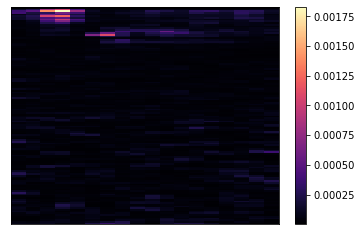

In [19]:
#audio_segment = audio_segment * (2**32)
#D = librosa.stft(audio_segment)  # STFT of y
D = librosa.feature.melspectrogram(audio_segment, sr=22050, n_fft=1024, hop_length=256, n_mels=128, fmax=11025)
#D_pcen = librosa.core.pcen(D, 22050)
#D_pcen_n = gen.feature_scale(D_pcen)

#D_filt = scipy.ndimage.median_filter(D_pcen, (3,2))

#S_db = librosa.power_to_db(np.abs(D), ref=np.max)
#print(S_db.shape)
print(D.shape)
plt.figure()
librosa.display.specshow(D)
#librosa.display.specshow(D_pcen)
#librosa.display.specshow(D_pcen_n)
plt.colorbar()

In [5]:
X, Y = gen.generate_train()

In [13]:
mask = np.zeros((100,17,128))
mask[:,:,100:] = 1
mask

array([[[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       ...,

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1.

In [16]:
X[200:300] = X[200:300] * mask

ValueError: operands could not be broadcast together with shapes (100,17,128) (5,15) 

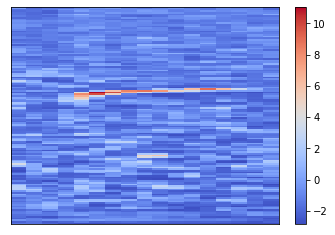

In [18]:
plt.figure()

librosa.display.specshow(gen.feature_scale(X[17010].T))
plt.colorbar()

In [17]:

import h5py as hf

In [18]:
gen_val = dg.TestDatagen(hf.File('/home/willbo/data/dcase/features/hfiles/val/BUK5_20180921_015906a.h5', 'r'), config)



In [19]:
X_pos, X_neg, X_query = gen_val.generate_eval()

In [54]:
len(X_pos)

7

In [20]:
mask = np.zeros((17,128))
mask[:,110:120] = 1

In [6]:
plt.figure()
librosa.display.specshow((X_pos[0]).T)
plt.colorbar()

NameError: name 'X_pos' is not defined

<Figure size 432x288 with 0 Axes>

In [26]:
import numpy as np

mask = np.zeros((5, 15))
mask[:,10:15] = 1

mask.T

mask_c = np.ones((5,15))
mask_c[:,10:15] = 0

mask_c.T

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])